In [1]:
# Import main packages
import sys, os
sys.path.insert(1, os.path.abspath('..') )
from ECO import diagnostics as eco
from ECO.utils import config_parser, open_datasets, get_namelist
import xarray as xr
import xgcm
import numpy as np

# Import matplotlib for plotting and functions to override default values
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from plot_utils import update_plotstyle, cmap_OB
cmap_OB=cmap_OB(); update_plotstyle()

In [3]:
exp_prefix = ['EXP00','EXP01'] # Import all files with this prefix
exp_suffix = ['_1d10','_1d10']
ds = open_datasets(exp_prefix, exp_suffix, components = ['all'],timestep_slice=(0,360))
if type(ds) != dict: ds={exp_prefix+exp_suffix:ds}

[PosixPath('../data/processed/EXP00/EXP00_1d10/domain/metrics_0_360.nc'), PosixPath('../data/processed/EXP00/EXP00_1d10/domain/masks_0_360.nc')]


HDF5-DIAG: Error detected in HDF5 (1.12.2) MPI-process 0:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 476 in H5O__attr_open_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #006: H5Adense.c line 394 in H5A__dense_open(): can't locate attribute in name index
    major: Attribute
    minor: Object

[PosixPath('../data/processed/EXP01/EXP01_1d10/domain/metrics_0_360.nc'), PosixPath('../data/processed/EXP01/EXP01_1d10/domain/masks_0_360.nc')]


HDF5-DIAG: Error detected in HDF5 (1.12.2) MPI-process 0:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 476 in H5O__attr_open_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #006: H5Adense.c line 394 in H5A__dense_open(): can't locate attribute in name index
    major: Attribute
    minor: Object

In [4]:
# get base configuration of EXP00
kwargs={}
#kwargs[exp_prefix+exp_suffix] = config_parser(exp_prefix)
for i in range(len(exp_prefix)): kwargs[exp_prefix[i]+exp_suffix[i]] = config_parser(exp_prefix[i])
#if kwargs_sim['get_namelist']: kwargs_sim['namelist'] = get_namelist(path = kwargs_proc['path_nemo'])

# define xgcm configuration based on dataset metrics
_metrics = {('X',): ['e1tm', 'e1um', 'e1vm', 'e1fm'],
     ('Y',): ['e2tm', 'e2um', 'e2vm', 'e2fm'],
     ('Z',): ['e3tm', 'e3um', 'e3vm', 'e3wm']}

grid = {exp: xgcm.Grid(ds[exp], metrics=_metrics, periodic=False) for exp in ds} # define xgcm grid
grid_ops = {exp: eco.Grid_ops(grid[exp], maskargs={'mask':'nan'}) for exp in ds} # define gridoperations.
grid = {exp: grid_ops[exp]._update({'Z':ds[exp]['e3tm_1d']}) for exp in ds}
        
properties= {exp: eco.Properties(grid_ops[exp], {'X': ds[exp].glamt, 'Y': ds[exp].gphit, 'Z': ds[exp].depth_1d}, eos_properties=kwargs[exp][2]['eos']) for exp in ds}
energetics= {exp: eco.Energetics(grid_ops[exp], properties[exp]) for exp in ds}

Using processing configuration base.yml
Using processing configuration base.yml


In [34]:
phi = ds['EXP00_1d10'].gphit[:,0]
lam = ds['EXP00_1d10'].glamt[0,:]
depth = properties['EXP00_1d10'].coords['Z']
YZ,ZY = np.meshgrid(phi.values,depth.values[:-1])
XY,YX = np.meshgrid(lam.values,phi.values)

/proj/climategu/users/x_bensc/Analysis/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/climategu/users/x_bensc/Analysis/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


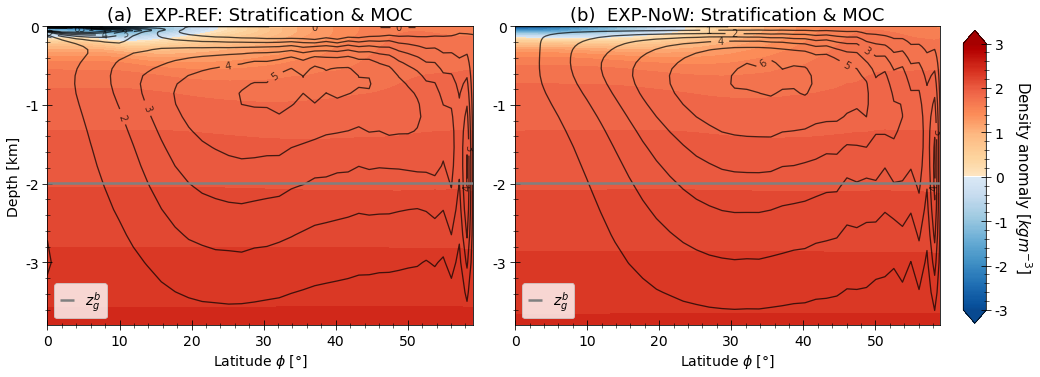

In [56]:
fig, ax = plt.subplots(1,2,figsize=(16,5.5))

for i, exp in enumerate(ds):
    dn = grid_ops[exp].average(ds[exp].rho-1026,'X').mean('t')#.values-1000
    vmin = -3
    vmax = 3
    qcs=ax[i].contourf(YZ, ZY, dn[:-1], cmap=cmap_OB,extend='both', levels=np.linspace(-3,3,41))
    

    vmin=-6
    vmax=6
    c = ax[i].contour(YZ, ZY, ds[exp].psi.mean('t')[:-1], colors='k',levels=np.linspace(0,6,7),linewidths=1.3,alpha=.7)
    ax[i].hlines(ds[exp].zg_0.mean('t'),0,60, color='grey',label='$z_g^b$')
    ax[i].clabel(c)
    #ax[i].set_title('(b) Meridional overturning circulation',fontsize=18)
    ax[i].set_xlabel('Latitude $\phi$ [°]',fontsize=14)
    ax[i].set_yticks([-4000,-3000,-2000,-1000,0])
    ax[i].set_yticklabels([0,-1,-2,-3,-4][::-1])
    ax[i].set_ylim(-3800,0)
    ax[i].set_xlim(0,59) 

    prefix = ['(a)  ','(b)  '] 
    prefix1 = ['EXP-REF: ','EXP-NoW: '] 
    suffix = ['Stratification & MOC', 'Stratification & MOC']
    ax[i].set_title(prefix[i]+prefix1[i]+suffix[i],fontsize=18)
    ax[i].legend(fontsize=14,handlelength=1,loc='lower left')
ax[0].set_ylabel('Depth [km]',fontsize=14)
ax_cb=fig.add_axes([0.92, 0.13, 0.02, 0.74])
cbar=plt.colorbar(ScalarMappable(norm=qcs.norm, cmap=qcs.cmap),ax=ax_cb,cax=ax_cb,
             ticks=np.arange(vmin, vmax+1, 1),
             extend='both', pad=0.02)

cbar.set_ticklabels(cbar.get_ticks())
#cbar.set_label('$\Psi_{moc}$ [Sv]',rotation=-90,labelpad=25,fontsize=15)
cbar.set_label(r'Density anomaly [$kg m^{-3}$]',rotation=-90,labelpad=25,fontsize=15)

plt.subplots_adjust(wspace=0.1)
plt.savefig('figures/Fig4_final.png', dpi=150, transparent=True, bbox_inches='tight')

In [54]:
c.collections[0].set

/proj/climategu/users/x_bensc/Analysis/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


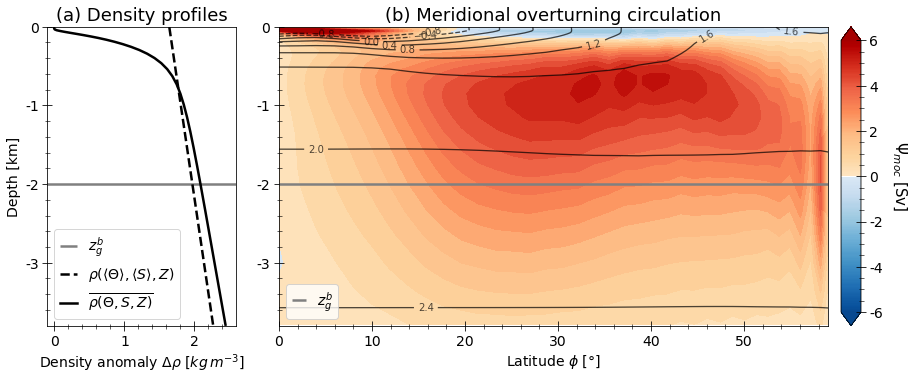

In [55]:
%matplotlib inline 
gs_kw = dict(width_ratios=[1,3.5])
fig, ax = plt.subplots(1,2,figsize=(16,5.5), gridspec_kw=gs_kw)#,constrained_layout=True)#, gridspec_kw=gs_kw)
ax[0],ax[1]=ax[1],ax[0]
lam = ds['EXP00_1d10'].gphit[:,0]
depth = properties['EXP00_1d10'].coords['Z']
X,Y = np.meshgrid(lam.values,depth.values[:-1])

vmin = 25.5
vmax = 28.5#.5
dn = grid_ops['EXP00_1d10'].average(ds['EXP00_1d10'].rho-1026,'X').mean('t')#.values-1000
c=ax[0].contour(X, Y, dn.where(dn>-1)[:-1], colors='k',levels=8,linewidths=1.3,alpha=.7)
ax[0].clabel(c)

vmin=-6
vmax=6
qcs = ax[0].contourf(X,Y, ds['EXP00_1d10'].psi.mean('t')[:-1], cmap=cmap_OB,vmin=vmin,vmax=vmax, levels=35)
ax[0].hlines(ds['EXP00_1d10'].zg_0.mean('t'),0,60, color='grey',label='$z_g^b$')#,linewidth=1)

# ax_cb=fig.add_axes([0.8, 0.13, 0.02, 0.74])
# cbar=plt.colorbar(ScalarMappable(norm=qcs.norm, cmap=qcs.cmap),ax=ax_cb,cax=ax_cb,
#              ticks=np.arange(vmin, vmax+1, 1),
#              extend='both', pad=0.02)
cbar=plt.colorbar(ScalarMappable(norm=qcs.norm, cmap=qcs.cmap),ax=ax[0],
             ticks=np.arange(vmin, vmax+1, 2),
             extend='both', pad=0.02, aspect=15)

cbar.set_ticklabels(cbar.get_ticks())
cbar.set_label('$\Psi_{moc}$ [Sv]',rotation=-90,labelpad=25,fontsize=15)

ax[0].set_title('(b) Meridional overturning circulation',fontsize=18)
ax[0].set_xlabel('Latitude $\phi$ [°]',fontsize=14)
ax[0].set_yticks([-4000,-3000,-2000,-1000,0])
ax[0].set_yticklabels([0,-1,-2,-3,-4][::-1])
ax[0].set_ylim(-3800,0)
ax[0].set_xlim(0,59)
ax[0].legend(fontsize=14,handlelength=1,loc='lower left')

ax[1].set_title('(a) Density profiles',fontsize=18)
ax[1].hlines(ds['EXP00_1d10'].zg_0.mean('t'),-1,3, color='grey',label='$z_g^b$')#,linewidth=1)
ax[1].plot(ds['EXP00_1d10'].rho_gm.mean('t')-1026,depth,c='k',linestyle='--',label=r'$\rho(\langle\Theta\rangle,\langle S\rangle,Z)$')
ax[1].plot(grid_ops['EXP00_1d10'].average(ds['EXP00_1d10'].rho,['X','Y']).mean('t')-1026,depth,c='k',label=r'$\overline{\rho(\Theta,S,Z)}$')
ax[1].set_yticks([-4000,-3000,-2000,-1000,0])
ax[1].set_yticklabels([0,-1,-2,-3,-4][::-1])
ax[1].set_ylim(-3800,0)
ax[1].set_xlim(-0.1,2.6)
ax[1].set_ylabel('Depth [km]',fontsize=14)
#ax[1].set_ylabel('Depth [km]',fontsize=14)
ax[1].set_xlabel(r'Density anomaly $\Delta \rho$ [$kg\,m^{-3}$]',fontsize=14)
ax[1].legend(fontsize=14, handlelength=1.2)
plt.subplots_adjust(wspace=0.1)
plt.savefig('figures/Fig3_final.png', dpi=150, transparent=True, bbox_inches='tight')

In [25]:

ds['EXP00_1d10'].zg_0.mean('t').values

array(-1997.07260478)